<a href="https://colab.research.google.com/github/jeetThakkar10/Quora-Case-Study/blob/main/CaseStudy1_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
# from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
# from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [ ]:
df= pd.read_csv(r"/content/drive/MyDrive/ML Datasets/CaseStudy1 - Quora/final_features.csv")

In [ ]:
df = df.sample(frac=0.6)
print(df.shape)


(242574, 797)


In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
y_true = df['is_duplicate']
df.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)
df.head()


,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
127095,0.428565,0.299997,0.333328,0.249997,0.312498,0.217390,0.0,0.0,7.0,19.5,...,-19.384046,-1.503264,11.551883,-8.237301,20.849400,0.939299,-12.426566,10.345075,25.599876,2.946757
62888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,3.0,9.5,...,13.750981,5.458715,21.816339,-9.092954,8.724053,-3.072579,-8.111194,-1.906479,8.042303,1.050176
14270,0.857131,0.857131,0.999980,0.999980,0.846147,0.846147,1.0,1.0,0.0,13.0,...,-7.244227,12.378529,24.331929,-9.653174,-7.892694,-1.193187,-17.159937,6.036631,8.819773,2.030314
71790,0.571420,0.499994,0.571420,0.499994,0.571424,0.444442,0.0,1.0,4.0,16.0,...,8.300198,28.632936,1.113562,-10.167538,15.376122,2.036291,-22.399951,28.200520,6.762986,-5.654028
208115,0.599988,0.599988,0.000000,0.000000,0.374995,0.333330,0.0,0.0,1.0,8.5,...,-9.694700,4.889549,-1.875900,-0.094378,-7.689807,-10.106847,-1.414914,29.885954,-9.155207,-12.658884


In [ ]:
type(df.ctc_max[0])

numpy.float64

In [ ]:
# Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df, y_true, test_size=0.3, stratify=y_true)
# Stratify = y_true means data is split, considering y_true as the class label. 

In [ ]:
print("Number of points in train data = {}".format(X_train.shape))
print("Number of points in test data = {}".format(X_test.shape))

Number of points in train data = (169801, 794)
Number of points in test data = (72773, 794)


In [ ]:
print("-"*10, "Distribution of output variable in train data ", "-"*10)
train_dist = Counter(Y_train)
train_len = len(Y_train)
test_dist = Counter(Y_test)
test_len = len(Y_test)
print("Class 0 :", int(train_dist[0])/train_len, "Class 1 :", int(train_dist[1])/train_len)
print("-"*10, "Distribution of output variable in test data ", "-"*10)
print("Class 0 :", int(test_dist[0])/test_len, "Class 1 : ", int(test_dist[1])/test_len)

---------- Distribution of output variable in train data  ----------
Class 0 : 0.6305616574696262 Class 1 : 0.3694383425303738
---------- Distribution of output variable in test data  ----------
Class 0 : 0.630563533178514 Class 1 :  0.369436466821486


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8868478949904309


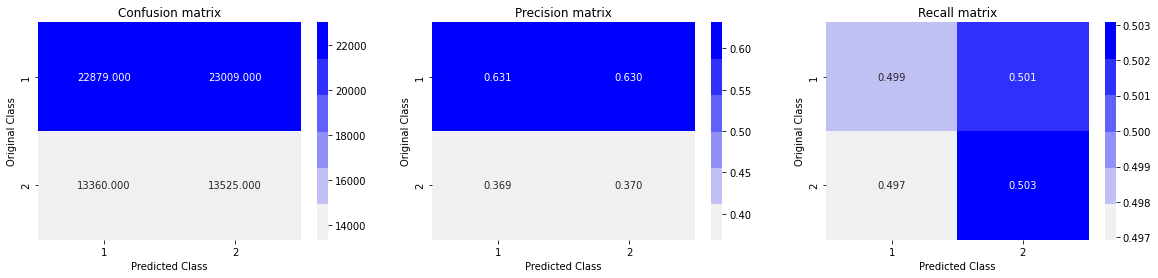

In [ ]:
import random
predicted_y = np.zeros((test_len,2))    # 
for i in range(test_len):
    rand_probs = np.random.rand(1,2)    # Generate a 1X2 matrix with random numbers
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])    # Findinf the probability
print("Log loss on Test Data using Random Model",log_loss(Y_test, predicted_y, eps=1e-15))    # Computing logloss


predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(Y_test, predicted_y)

In [ ]:
alpha = [10**x for x in range(-5,2)]

log_error_array = []
for i in alpha:
  clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
  clf.fit(X_train, Y_train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(X_train, Y_train)
  predict_y = sig_clf.predict_proba(X_test)
  log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
  print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 0.4364667002783137
For values of alpha =  0.0001 The log loss is: 0.4361352209685007
For values of alpha =  0.001 The log loss is: 0.4412350419211535
For values of alpha =  0.01 The log loss is: 0.4269729140775949
For values of alpha =  0.1 The log loss is: 0.44521265078792627
For values of alpha =  1 The log loss is: 0.4722880596614486
For values of alpha =  10 The log loss is: 0.5150457755822752


In [ ]:
best_alpha = np.argmin(log_error_array)

clf=SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, Y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train, Y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.01, loss='log',
                                                    random_state=42))